# Continuous-time Estimation

## B-spline for SE(3)

Unlike [Bezier curve](https://en.wikipedia.org/wiki/B%C3%A9zier_curve), B-spline has local controllability. In other words, a segment of a B-spline curve is only controlled by $k$ control points, where $k$ is the degree of the B-spline curve. A B-spline is defined as below:
$$
\begin{align}
p(t) = \sum_{i=0}^{i=n}B_{i,k}(t)p_i
\end{align}
$$
Where $p_i$ is the $i^{th}$ control points, $B_{i,k}$ is the coefficient of $p_i$. The local controllability comes from that $B(t)$ is equal to 0 for certain segments. 

In order to define $B_{i,k}(t)$, we need first define a knot vector $\tau = [\tau_0, \cdots, \tau_m]$, where $\tau_i \leq \tau_{i+1}$.
$$
\begin{align}
B_{i, 0}(t) &= \begin{cases}
1, & \tau_i \leq t < \tau_{i+1} \\
0, & otherwise
\end{cases}
\end{align}
$$

$$
\begin{align}
B_{i, k}(t) &= \frac{t-\tau_i}{\tau_{i+k}-\tau_i}B_{i,k-1} + \frac{\tau_{i+1+k}-t}{\tau_{i+1+k}-\tau_{i+1}}B_{i+1,k-1}
\end{align}
$$

There are a couple of interesting things about $B_{i,k}(t)$:
- $m = n + 1 + k$, where we have $m+1$ knots, $n+1$ control points, degree as $k$. This requirement comes from we need to calculate value $\tau_{i+1+k}$.
- $B_{i,0}(t)$ is a step function which is 0 outside the span $[\tau_i, \tau_{i+1})$.
- $B_{i,k}(t)$ is always 0 outside the span $[\tau_i, \tau_{i+k+1})$.
- The curve is only **defined** within the span $[\tau_k, \tau_{n+1})$, and the summation of coefficients is equal to 1.
- The curve inside a valid unit span $[\tau_i, \tau_{i+1})$ is controlled by $k+1$ control points.

In [3]:
# B-spline functions
from scipy.interpolate import BSpline
from scipy import interpolate
import numpy as np

'''
@param x: query point
@param k: degree
@param i: i^th knot position
@param t: knot vector
@return return coefficient value
'''
def B(x, k, i, t): 
   if k == 0:
      return 1.0 if t[i] <= x < t[i+1] else 0.0
   if t[i+k] == t[i]:
      c1 = 0.0
   else:
      c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
   if t[i+k+1] == t[i+1]:
      c2 = 0.0
   else:
      c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
   return c1 + c2

def bspline(x, t, c, k):
   n = len(t) - k - 1
   assert (n >= k+1) and (len(c) >= n)
   return sum(c[i] * B(x, k, i, t) for i in range(n))
#

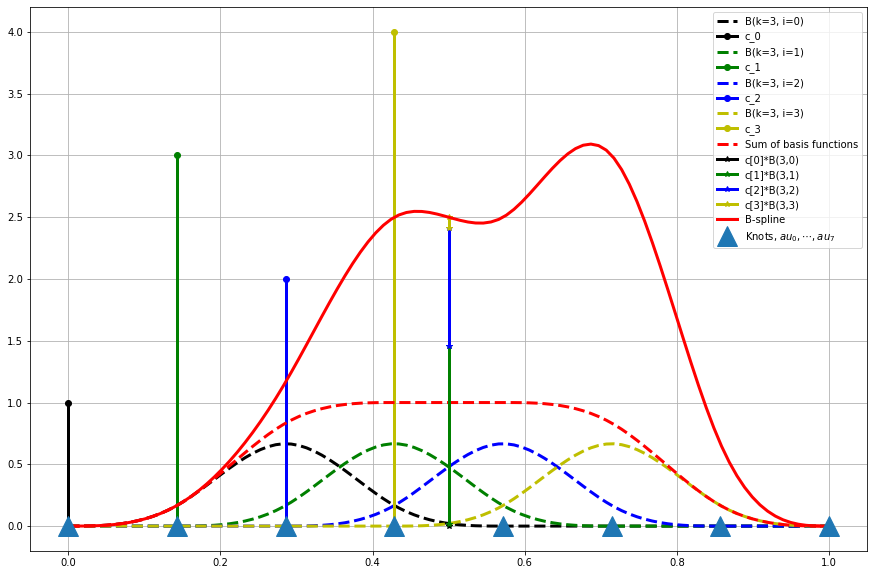

In [30]:
# A B-spline with uniform knots example

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

k = 3
c = [1, 3, 2, 4]
un_normalized_t = [0, 1, 2, 3, 4, 5, 6, 7]
t = np.array(un_normalized_t)
t = (t - un_normalized_t[0]) / (un_normalized_t[-1] - un_normalized_t[0])

assert(len(t) == len(c) + k + 1)

fig, ax = plt.subplots()
xx = np.linspace(t[0], t[-1], 100)
colors = ['k', 'g', 'b', 'y']
n = len(c)
for i in range(n):
    ax.plot(xx, [B(u, k, i, t) for u in xx], colors[i]+'--', lw=3, label=f'B(k={k}, i={i})')
    ax.plot([t[i], t[i]], [0, c[i]], colors[i]+'-o', lw=3, label=f'c_{i}')

# Valid region [k, len(t)-k-1]
ax.plot(xx, [ sum([B(u, k, i ,t) for i in range(n)]) for u in xx],
        'r--', lw=3, label='Sum of basis functions')

u = 0.5
acc_y = 0
for i in range(n):
    c_B = c[i]*B(u, k, i, t)
    ax.plot([u, u], [acc_y, acc_y + c_B], colors[i]+'-*', lw=3, label=f'c[{i}]*B({k},{i})')
    acc_y += c_B
ax.plot(xx, [bspline(x, t, c ,k) for x in xx], 'r-', lw=3, label='B-spline')
ax.plot([x for x in t], [0 for x in t], '^', markersize=20, label='Knots, $\tau_0, \cdots, \tau_7$')

# tck=[t, np.array(c), k]
# ax.plot(xx, interpolate.splev(xx, tck), 'g--', lw=3, label='Bspline lib')

#spl = BSpline(t, c, k, extrapolate=False)
#ax.plot(xx, spl(xx), 'r-', lw=3, label='Bspline lib')


ax.grid(True)
ax.legend(loc='best')
plt.show()

#

### Matrix Representation for Uniform Basis

### Matrix Form for Uniform Cumulative Basis 

### Strangeness of Using B-spline Interpolation based on Timestamp

**Though there are papers using B-spline for interpolation based on time, I don't quite get it because it seems odd to me that the defined span is controlled by control points that have timestamps smaller than its start time.** Interpreting values in knot vector as timestamps seems incorrect to me. For example, the controls points in the figure above are at $\tau_0, \tau_1, \tau_2, \tau_3$. They control the curve shape defined at $[\tau_3, \tau_4)$ for degree $k=3$. Nevertheless, if knots are uniform, then it does seem that the curve can be used for interpolation between $\tau_1$ and $\tau_2$. This is because that the weight for control point $c_1$ (green curve) reaches the largest value at the $\tau_3$ and the weight for control point $c_2$ (blue curve) reaches the largest value at the $\tau_4$. 

If we use non-uniform knots, the how could we describe a proper time-based interpolation between $\tau_1, \tau_2$ given the B-spline curve defined in $[\tau_3, \tau_4)$.  **So then how would a non-uniform knot vector work for the interpolation based on time? I don't know.** 

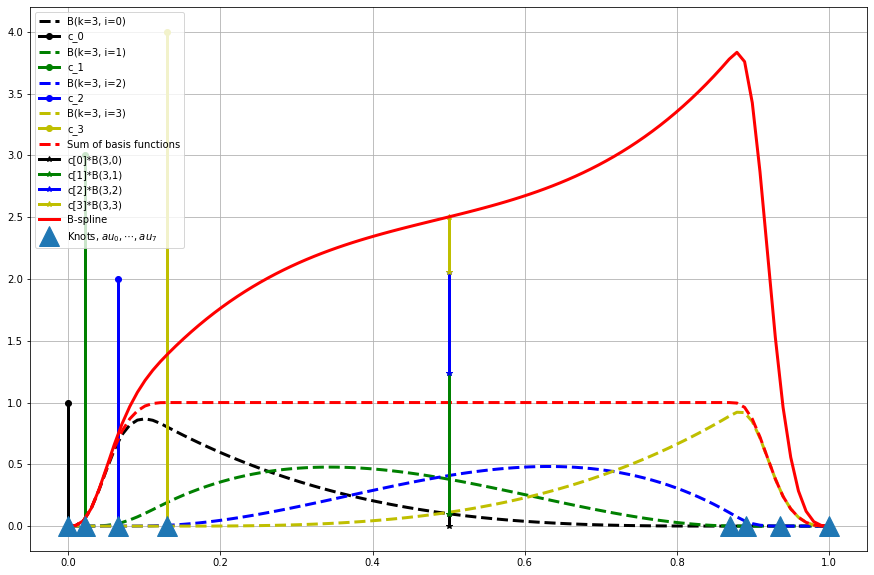

In [31]:
# A B-spline with non-uniform knots example

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

k = 3
c = [1, 3, 2, 4]
un_normalized_t = [0, 0.1, 0.3, 0.6, 4, 4.1, 4.3, 4.6]
t = np.array(un_normalized_t)
t = (t - un_normalized_t[0]) / (un_normalized_t[-1] - un_normalized_t[0])

assert(len(t) == len(c) + k + 1)

fig, ax = plt.subplots()
xx = np.linspace(t[0], t[-1], 100)
colors = ['k', 'g', 'b', 'y']
n = len(c)
for i in range(n):
    ax.plot(xx, [B(u, k, i, t) for u in xx], colors[i]+'--', lw=3, label=f'B(k={k}, i={i})')
    ax.plot([t[i], t[i]], [0, c[i]], colors[i]+'-o', lw=3, label=f'c_{i}')

# Valid region [k, len(t)-k-1]
ax.plot(xx, [ sum([B(u, k, i ,t) for i in range(n)]) for u in xx],
        'r--', lw=3, label='Sum of basis functions')

u = 0.5
acc_y = 0
for i in range(n):
    c_B = c[i]*B(u, k, i, t)
    ax.plot([u, u], [acc_y, acc_y + c_B], colors[i]+'-*', lw=3, label=f'c[{i}]*B({k},{i})')
    acc_y += c_B
ax.plot(xx, [bspline(x, t, c ,k) for x in xx], 'r-', lw=3, label='B-spline')
ax.plot([x for x in t], [0 for x in t], '^', markersize=20, label='Knots, $\tau_0, \cdots, \tau_7$')

# tck=[t, np.array(c), k]
# ax.plot(xx, interpolate.splev(xx, tck), 'g--', lw=3, label='Bspline lib')

#spl = BSpline(t, c, k, extrapolate=False)
#ax.plot(xx, spl(xx), 'r-', lw=3, label='Bspline lib')


ax.grid(True)
ax.legend(loc='best')
plt.show()

#

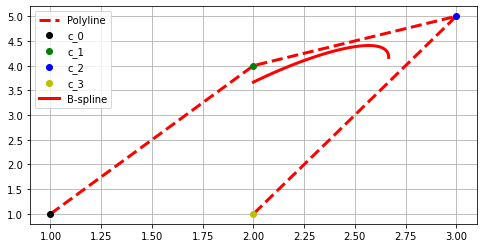

In [20]:
# A 2D B-spline with uniform knots example
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

k = 3
c = np.array([(1,1), (2,4), (3, 5), (2, 1)])
un_normalized_t = [0, 1, 2, 3, 4, 5, 6, 7]
t = np.array(un_normalized_t)
t = (t - un_normalized_t[0]) / (un_normalized_t[-1] - un_normalized_t[0])

assert(len(t) == len(c) + k + 1)

fig, ax = plt.subplots()
colors = ['k', 'g', 'b', 'y']
n = len(c)
ax.plot(c[:, 0], c[:, 1], 'r--', lw=3, label=f'Polyline')
for i in range(n):
    ax.plot(c[i, 0], c[i, 1], colors[i]+'o', lw=3, label=f'c_{i}')


# Valid region [k, n]
xx = np.linspace(t[k], t[n], 100)
bspline_curve_x = []
bspline_curve_y = []
for x in xx:
    p = bspline(x, t, c ,k)
    bspline_curve_x.append(p[0])
    bspline_curve_y.append(p[1])
    
ax.plot(bspline_curve_x, bspline_curve_y,
        'r-', lw=3, label='B-spline')


ax.grid(True)
ax.legend(loc='best')
plt.show()

#

### B-spline with uniform knots for SE(3)

As mentioned in the last section, though it doesn't seem correct to me mathematically, B-spline with uniform knots can be considered to use for time-based interpolation. When using uniform knots, we actually don't need to calculate coefficients $B$ recursively. We have a well-defined matrix form for B-spline.

Reference:
- Patron-Perez et al. `A spline-based trajectory represen- tation for sensor fusion and rolling shutter cameras`
- Kaihuai Qin. `General matrix representations for B-splines`
- http://ae.sharif.edu/~aerocad/curve%20modelling-B_Spline.pdf
- http://www.inf.ed.ac.uk/teaching/courses/cg/d3/nonbspline.html

## Gaussian Processes for SE(3)

Reference:
- Barfoot `State Estimation for Robotics`